In [1]:
from fastai.vision.all import *

In [2]:
def train_fairface_model(train_df, arch=resnet34, epochs=10, bs=64, lr=1e-3):
    fairface_block = DataBlock(
        blocks=(ImageBlock, MultiCategoryBlock),
        get_x=ColReader('file', pref='./Dataset/'),  
        get_y=ColReader(['age', 'gender', 'race']),
        splitter=ColSplitter('is_valid'),  
        item_tfms=Resize(224),
        batch_tfms=aug_transforms(mult=1.0, max_rotate=20.0, max_zoom=1.2, max_warp=0.2, p_affine=0.75)
    )

    dls = fairface_block.dataloaders(train_df, bs=bs)

    learn = vision_learner(dls, arch, metrics=[partial(accuracy_multi, thresh=0.5)])

    learn.lr_find()

    learn.fine_tune(
        epochs,
        base_lr=lr,
        cbs=[
            SaveModelCallback(monitor='valid_loss'),
            EarlyStoppingCallback(monitor='valid_loss', patience=3), 
            ReduceLROnPlateau(monitor='valid_loss', patience=2)  
        ]
    )

    learn.export('../models/fairface_v3.pkl')
    torch.save(learn.model.state_dict(), '../models/fairface_v3.pth')

    return learn



epoch,train_loss,valid_loss,accuracy_multi,time
0,0.312984,0.292017,0.879455,11:59


Better model found at epoch 0 with valid_loss value: 0.2920166552066803.


epoch,train_loss,valid_loss,accuracy_multi,time
0,0.250071,0.231559,0.900711,15:20
1,0.223263,0.204589,0.909795,15:21
2,0.209798,0.192274,0.914724,15:19
3,0.196702,0.186141,0.917037,15:20
4,0.192788,0.181119,0.919654,15:43
5,0.180249,0.178465,0.920704,15:42
6,0.177424,0.176826,0.921612,15:42
7,0.164861,0.177060,0.922123,15:32
8,0.153720,0.176465,0.922762,15:32
9,0.157552,0.176630,0.922525,15:30


Better model found at epoch 0 with valid_loss value: 0.2315593659877777.
Better model found at epoch 1 with valid_loss value: 0.20458920300006866.
Better model found at epoch 2 with valid_loss value: 0.19227419793605804.
Better model found at epoch 3 with valid_loss value: 0.18614114820957184.
Better model found at epoch 4 with valid_loss value: 0.18111927807331085.
Better model found at epoch 5 with valid_loss value: 0.17846494913101196.
Better model found at epoch 6 with valid_loss value: 0.17682571709156036.
Better model found at epoch 8 with valid_loss value: 0.1764654815196991.
Epoch 10: reducing lr to 1.7298986320982146e-06
Better model found at epoch 11 with valid_loss value: 0.17645017802715302.


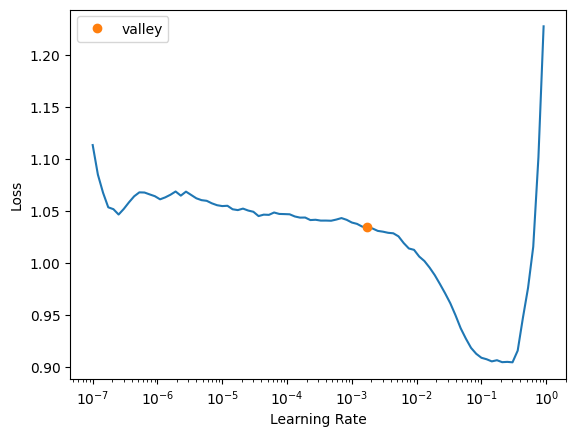

In [3]:
train_df = pd.read_csv('./Dataset/fairface_label_train.csv').drop(columns=['service_test'])
val_df = pd.read_csv('./Dataset/fairface_label_val.csv').drop(columns=['service_test'])

train_df['is_valid'] = False
val_df['is_valid'] = True

combined_df = pd.concat([train_df, val_df])

learn = train_fairface_model(combined_df, arch=resnet50, epochs=12, bs=32, lr=1e-3)

In [7]:
age_labels = ['0-2', '3-9', '10-19', '20-29', '30-39', '40-49', '50-59', '60-69', 'more than 70']
gender_labels = ['Male', 'Female']
race_labels = ['White', 'Black', 'East Asian', 'Southeast Asian', 'Indian', 'Middle Eastern', 'Latino_Hispanic']

def predict_and_print_probs_all(img_path):
    img = PILImage.create(img_path)

    pred, pred_idx, probs = learn.predict(img)

    age_probs = probs[:len(age_labels)]
    gender_probs = probs[len(age_labels):len(age_labels) + len(gender_labels)]
    race_probs = probs[len(age_labels) + len(gender_labels):]

    def print_probabilities(label_type, labels, probabilities):
        print(f"\n{label_type} Category Probabilities:")
        for label, prob in zip(labels, probabilities):
            print(f'{label}: {prob:.4f}')

    print_probabilities("Age", age_labels, age_probs)
    print_probabilities("Gender", gender_labels, gender_probs)
    print_probabilities("Race", race_labels, race_probs)

def predict_and_print_probs_2(img_path):
    img = PILImage.create(img_path)

    pred, pred_idx, probs = learn.predict(img)

    age_probs = probs[:len(age_labels)]
    gender_probs = probs[len(age_labels):len(age_labels) + len(gender_labels)]
    race_probs = probs[len(age_labels) + len(gender_labels):]
    
    def print_top_k_probabilities(label_type, labels, probabilities, k=1):
        print(f"\nTop-{k} {label_type} Predictions:")
        top_k = sorted(zip(labels, probabilities), key=lambda x: x[1], reverse=True)[:k]
        for label, prob in top_k:
            print(f'{label}: {prob:.4f}')

    print_top_k_probabilities("Age", age_labels, age_probs, k=4)  
    print_top_k_probabilities("Gender", gender_labels, gender_probs, k=4)
    print_top_k_probabilities("Race", race_labels, race_probs, k=4)


predict_and_print_probs_2('./Dataset/val/116.jpg')


Top-4 Age Predictions:
3-9: 0.6803
10-19: 0.1317
20-29: 0.0488
30-39: 0.0043

Top-4 Gender Predictions:
Female: 0.9967
Male: 0.0004

Top-4 Race Predictions:
Black: 0.5511
Middle Eastern: 0.2362
Southeast Asian: 0.1246
White: 0.0120
